<a href="https://colab.research.google.com/github/AArna1211/Traffic-prediction/blob/main/TP_CNN%2BBiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Flatten, Dense, Dropout, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
data = pd.read_csv("/content/Traffic.csv")

In [11]:
# Encode categorical "Traffic Situation"
label_encoder = LabelEncoder()
data["Traffic Situation Encoded"] = label_encoder.fit_transform(data["Traffic Situation"])

# Prepare features and labels
X = data[["CarCount", "BikeCount", "BusCount", "TruckCount", "Total"]].values
y = data["Traffic Situation Encoded"].values


In [12]:
# Reshape input for time-series forecasting (sequence length = 3 for long-term prediction)
sequence_length = 3
X_sequences = []
y_sequences = []
for i in range(len(X) - sequence_length):
    X_sequences.append(X[i:i + sequence_length])
    y_sequences.append(y[i + sequence_length])
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

In [13]:
# Define CNN-Bidirectional LSTM model for long-term forecasting
model = Sequential([
    TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'), input_shape=(sequence_length, X.shape[1], 1)),
    TimeDistributed(Flatten()),
    Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
    Bidirectional(LSTM(32, activation='relu')),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [15]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=2, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6233 - loss: 1.0931 - val_accuracy: 0.7345 - val_loss: 0.9294
Epoch 2/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7275 - loss: 0.8299 - val_accuracy: 0.7277 - val_loss: 0.7929
Epoch 3/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6869 - loss: 0.8951 - val_accuracy: 0.7042 - val_loss: 0.7917
Epoch 4/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7173 - loss: 0.8059 - val_accuracy: 0.7361 - val_loss: 0.7511
Epoch 5/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7439 - loss: 0.7473 - val_accuracy: 0.7529 - val_loss: 0.6903
Epoch 6/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7377 - loss: 0.7723 - val_accuracy: 0.7143 - val_loss: 0.7251
Epoch 7/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7174 - loss: 0.7820 - val_accuracy: 0.7563 - val_loss: 0.6945
Epoch 8/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7435 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step
Test Accuracy: 0.7563
Mean Absolute Error: 0.4303


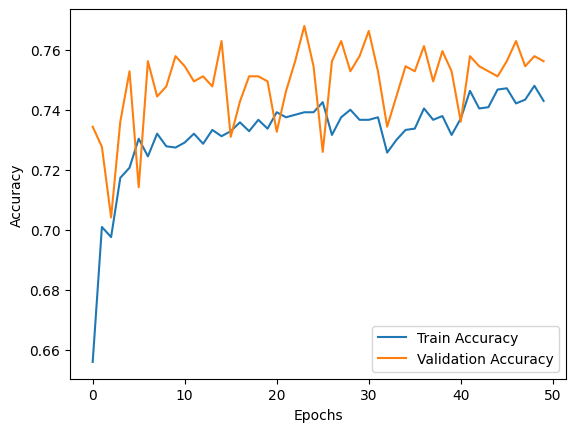

In [16]:
# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()